In [2]:

import mne


import pandas as pd
import mtrf
from mtrf.model import TRF
from mtrf.stats import crossval, nested_crossval


import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.io import wavfile, loadmat, savemat
from scipy.signal import hilbert

from collections import Counter

import sys
sys.path.append('../../utils')
from pp_utils import *
from plot_utils import *
from mTRF_utils import *
from midi_utils import *
from update_sub_lists import*
from ERP_utils import *

import pickle
import os

## Subjects and parameters

In [3]:

train = 'listen' #listen or motor or error
save = True
trigger = 'audio'
periods = ['post']


good_listen_subjects, good_motor_subjects,good_error_subjects,musicians,nonmusicians = load_subject_lists_LME()
# subjects_to_process = good_error_subjects
subjects_to_process = ['06']

n_subs = len(subjects_to_process)
print('processing subjects:', subjects_to_process)

periods = ['pre']
#features = 'AM' #AM or onsets

overwrite = False
n_segments = 10
fs = 128
tmin, tmax =-0.5, 0.5  # range of time lag
regularization = 1


eeg_dir = '../../data_preprocessed_15Hz'
sv_dir = './sv'
mTRF_path = f'./trained_models_backward_{train}'



processing subjects: ['06']


## Train reverse TRF model

In [4]:

for subject in subjects_to_process:
    print(f'processing subject {subject}')
    for period in periods:

        if train == 'error':
            eeg_path = os.path.join(eeg_dir, f'{subject}/eeg_error_{period}_{subject}.mat')
            
            data = loadmat(eeg_path)
            eeg = data['trial_data']

            #error events are already pre-extracted and sorted by first or others so sv can be customized to reflect surprisal
            sv_data = loadmat(os.path.join(sv_dir, f'sv_data_{period}_{subject}.mat'))
            onsets_sv = sv_data['onsets'][0] #take 0 index because it's shaped (1, n_timepoints)

        elif train == 'listen' or train == 'motor':
            eeg_path = os.path.join(eeg_dir, f'{subject}/eeg_{train}_{period}_{subject}.mat')
            data = loadmat(eeg_path)
            eeg = data['trial_data']
     
            
            #get listening events and make support vector
            events_sv = data['events']
            events_arr = make_raw_events(events_sv)

            #change triggers for subject 13+ if trigger is midi

            if train == 'motor':
                if trigger == 'audio':
                    keyboard_trig = 2
                elif trigger == 'MIDI':
                    keyboard_trig = 2 if int(subject) < 13 else 6
            else:
               keyboard_trig = 2

            events_keystrokes = clean_triggers(events_arr[events_arr[:, 2]==keyboard_trig])
            onset_indices = events_keystrokes[:,0]
            onsets_sv = np.zeros_like(events_sv[0])
            onsets_sv[onset_indices] = 1

        else:
           print('training has to be a valid task')
           break
        

        eeg_segments = segment(eeg.T, n_segments)
        eeg_segments_norm = normalize_responses(eeg_segments)

        onset_segments = segment(onsets_sv, n_segments) 


        #train model
        bwd_trf = TRF(direction = -1)
        bwd_trf.train(onset_segments, eeg_segments_norm, fs, tmin, tmax, regularization = regularization)

        #save model
        if save: 
         if not os.path.exists(mTRF_path):
            os.mkdir(mTRF_path)
         bwd_trf.save(os.path.join(mTRF_path, f'rTRF_{train}_{subject}_{period}.pkl'))

        

processing subject 06


## Using reverse TRF to predict stimulus

In [5]:
def load_stim_resp(subject, period, n_segments, eeg_dir, stim_dir, normalize = True, stim_sv = 'firsts'):
    """ 
    Loads the error eeg and onsets information
    stim_sv: either 'onsets' (loads sv where all onsets are 1) or 'firsts' (where all firsts are 1 and others are slightly smaller)
     ---
    returns:
    sv_segments: stimulus, segmented into n_segments
    eeg_segments: eeg response, segmented into n_segments
    """

    data_err = loadmat(os.path.join(eeg_dir, f'{subject}/eeg_error_{period}_{subject}.mat'))
    eeg_err = data_err['trial_data'].T

    
    sv_data_err = loadmat(os.path.join(stim_dir, f'sv_data_{period}_{subject}.mat'))

    if stim_sv == 'onsets':
        sv = sv_data_err['onsets'][0]
    elif stim_sv == 'firsts':
        sv = sv_data_err['firsts'][0]
    
    #crop EEG if it's longer than support vector (sv is always 10 mins long but subs 01 and 04 have shorter recordings)
    if sv.shape[0] > eeg_err.shape[0]:
        sv = sv[:eeg_err.shape[0]]

    
   
    eeg_segments = segment(eeg_err, n_segments)
    sv_segments = segment(sv,n_segments)

    #normalize EEG segmenets
    if normalize:
        eeg_segments = normalize_responses(eeg_segments)

    return sv_segments, eeg_segments


def concat_segments(segments):
    """
    reconcatenate segmented data
    """
    concat = np.stack(segments).squeeze()
    concat = concat.reshape(-1)
    return concat

def find_trf_preds(model, stimulus, response):
    """ 
    Predicts stimulus and concatenates the results so it can be easily plotted against ground truth

    ---
    Returns: 
    prediction (concatenated to be same shape as unsegmented stimulus)


    """
    #prediction using trf model
    res = model.predict(stimulus, response) 
        #res[0] is the prediction of the stimulus. List of len n_segments, where each element is the size of one stimlus segment
        #res[1] is a metric to measure how good the prediction is. By default it is pearson r

    #get reconstructed stimulus
    prediction = res[0]
    prediction = np.stack(prediction).squeeze()
    #concatenate prediction segments so they can be plotted against ground truth
    pred_concat = prediction.reshape(-1)

    #get prediction metric
    pred_metric = res[1]

    return pred_concat, pred_metric


def load_trf_model(subject, period, mTRF_path, task):
    with open(os.path.join(mTRF_path, f'rTRF_{task}_{subject}_{period}.pkl'), 'rb') as file:
        bwd_trf = pickle.load(file)
    return bwd_trf

In [8]:
train = 'listen'
preds_path = f'./rTRF_predictions_{train}/'

model_period = 'pre'
data_period = 'pre'
for subject in subjects_to_process:
    print(f'processing {subject}')

    sv, eeg = load_stim_resp(subject, data_period, n_segments, eeg_dir, sv_dir, stim_sv='onsets') #load stim
    
    #load model and predict
    bwd_trf = load_trf_model(subject, model_period, mTRF_path, train)
    pred_concat, pred_metric = find_trf_preds(bwd_trf, sv, eeg)

    #save predictions
    preds = {
        'predicted_stim': pred_concat,
        'pearsonr': pred_metric
    }

    if not os.path.exists(preds_path):
        os.mkdir(preds_path)

    # savemat(os.path.join(preds_path, f'pred_err_{subject}_data{data_period}_model{model_period}.mat'), preds)
    savemat(os.path.join(preds_path, f'pred_err_{subject}_{model_period}.mat'), preds)

processing 06


In [7]:
pred_concat.shape

(76800,)

Text(0, 0.5, 'amplitude')

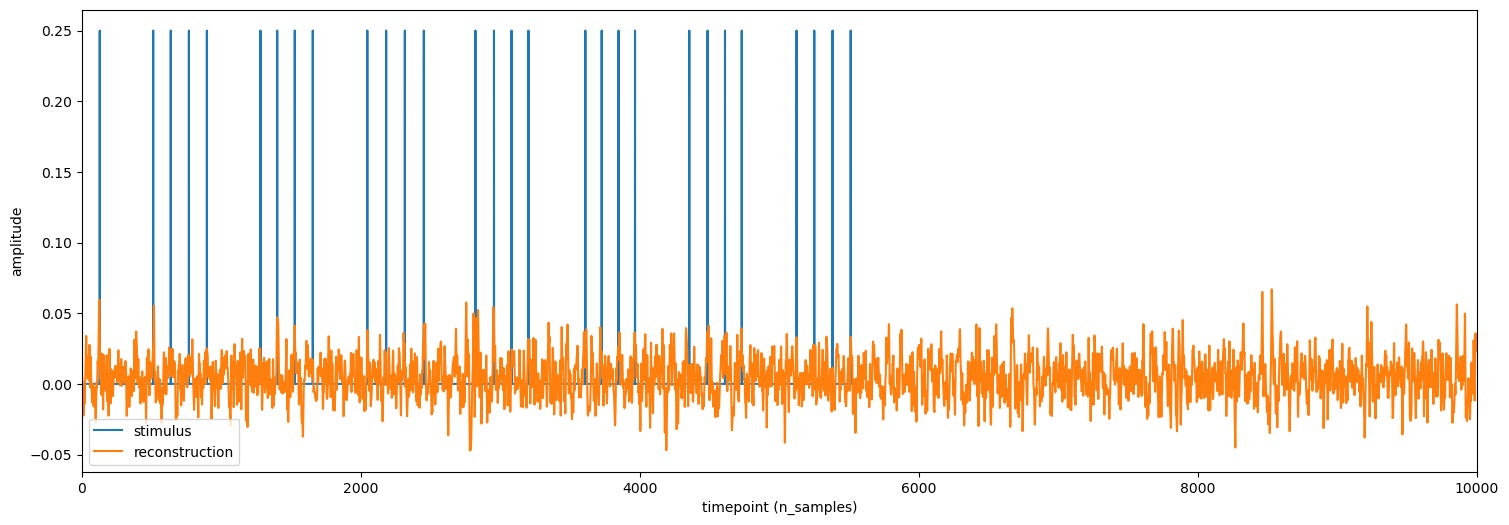

In [34]:
#sanity check


plt.figure(figsize = (18,6))
plt.plot(sv[0][0:10000]/4, label = 'stimulus')
plt.plot(pred_concat[0:10000], label = 'reconstruction')
plt.xlim(0,10000)

plt.legend(loc = 'lower left')
plt.xlabel('timepoint (n_samples)')
plt.ylabel('amplitude')